In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Transformasi dataset dengan augmentasi data
train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # Rotasi acak hingga 15 derajat
    transforms.RandomHorizontalFlip(),  # Membalik gambar secara horizontal
    transforms.RandomResizedCrop(32, scale=(0.88, 1.0)),  # Zoom acak hingga 12%
    transforms.RandomAffine(degrees=10, shear=10),  # Transformasi affine (shear hingga 10 derajat)
    transforms.ColorJitter(brightness=0.1),  # Ubah kecerahan hingga 10%
    transforms.ToTensor(),  # Konversi ke tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalisasi
])

# Transformasi dataset tanpa augmentasi untuk validasi dan test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalisasi
])


In [4]:
# Load dataset CIFAR-10 dengan transformasi yang sesuai
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Tentukan ukuran train dan validation
train_size = int(0.4 * len(train_dataset))  # untuk training
val_size = len(train_dataset) - train_size  # Sisanya untuk validation

# Split dataset menjadi train dan validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Buat DataLoader untuk train, validation, dan test set
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Informasi dataset
print(f"Jumlah data train: {len(train_dataset)}")
print(f"Jumlah data validasi: {len(val_dataset)}")
print(f"Jumlah data test: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Jumlah data train: 20000
Jumlah data validasi: 30000
Jumlah data test: 10000


In [8]:
# DataLoader sudah dibuat sebelumnya
print('Train Images Shape:      ', len(train_dataset))
print('Train Labels Shape:      ', len(train_dataset))

print('\nValidation Images Shape: ', len(val_dataset))
print('Validation Labels Shape: ', len(val_dataset))

print('\nTest Images Shape:       ', len(test_dataset))
print('Test Labels Shape:       ', len(test_dataset))


Train Images Shape:       20000
Train Labels Shape:       20000

Validation Images Shape:  30000
Validation Labels Shape:  30000

Test Images Shape:        10000
Test Labels Shape:        10000


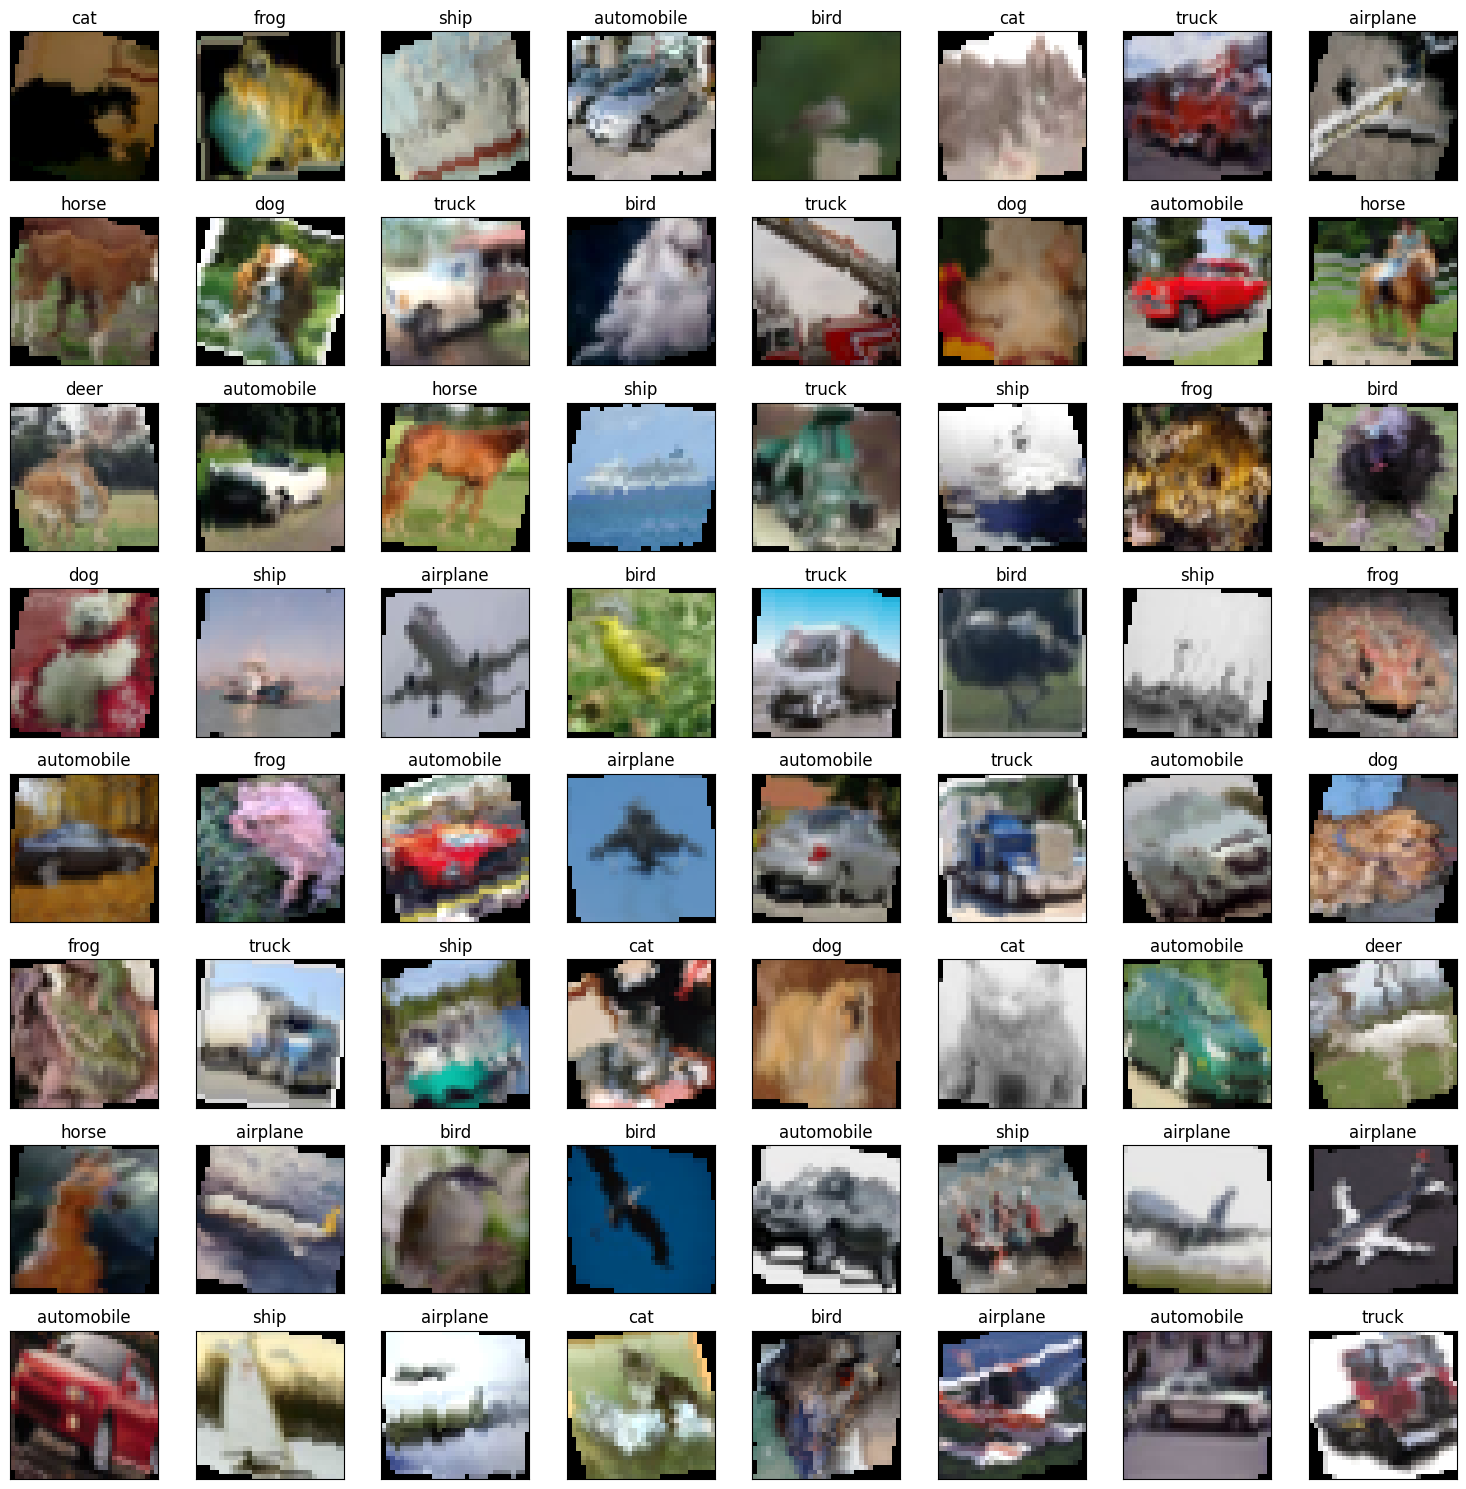

In [5]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Ambil batch pertama dari train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Pindahkan data ke CUDA (jika tersedia)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
images, labels = images.to(device), labels.to(device)

# Kembalikan data ke CPU untuk visualisasi
images = images.cpu()
labels = labels.cpu()

# Buat gambar grid
plt.figure(figsize=(15, 15))

# Loop untuk menampilkan 64 gambar pertama
for i in range(64):
    # Create subplot untuk setiap gambar
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Tampilkan gambar (denormalisasi)
    img = images[i].permute(1, 2, 0).numpy()  # Permutasi channel untuk RGB
    plt.imshow((img * 0.5) + 0.5)  # Denormalisasi agar gambar terlihat baik

    # Set label sebagai judul
    plt.title(class_names[labels[i].item()], fontsize=12)

# Tampilkan figure
plt.tight_layout()
plt.show()


In [5]:
import torch.nn.functional as F

# Konversi label ke tensor (jika belum dilakukan)
y_train = torch.tensor([label for _, label in train_dataset], dtype=torch.long)
y_valid = torch.tensor([label for _, label in val_dataset], dtype=torch.long)
y_test = torch.tensor([label for _, label in test_dataset], dtype=torch.long)

# Konversi ke one-hot encoding
num_classes = 10
y_train_one_hot = F.one_hot(y_train, num_classes=num_classes)
y_valid_one_hot = F.one_hot(y_valid, num_classes=num_classes)
y_test_one_hot = F.one_hot(y_test, num_classes=num_classes)

# Tampilkan bentuk data
print("Train Labels Shape (One-Hot):", y_train_one_hot.shape)
print("Validation Labels Shape (One-Hot):", y_valid_one_hot.shape)
print("Test Labels Shape (One-Hot):", y_test_one_hot.shape)

Train Labels Shape (One-Hot): torch.Size([20000, 10])
Validation Labels Shape (One-Hot): torch.Size([30000, 10])
Test Labels Shape (One-Hot): torch.Size([10000, 10])


In [6]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size=3, pooling_type='max', input_shape=(3, 32, 32), num_classes=10):
        super(CNNModel, self).__init__()
        
        if pooling_type == 'max':
            pooling_layer = nn.MaxPool2d
        elif pooling_type == 'avg':
            pooling_layer = nn.AvgPool2d
        else:
            raise ValueError("Invalid pooling_type. Choose 'max' or 'avg'.")

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_size, padding='same'),  # Updated to 3 input channels
            nn.ReLU(),
            pooling_layer(2, 2),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            pooling_layer(2, 2),
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (input_shape[1] // 4) * (input_shape[2] // 4), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [7]:
# Fungsi untuk menghitung metrik
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)  # Avoid undefined metric warning
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)        # Avoid undefined metric warning
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, precision, recall, f1


In [8]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50, device='cuda', patience=2):
    train_metrics, val_metrics = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        # Training step
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Collect predictions and labels for metrics
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

        epoch_train_loss = running_loss / len(train_loader)
        train_acc, train_precision, train_recall, train_f1 = calculate_metrics(all_labels, all_preds)

        # Validation step
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                # Collect predictions and labels for metrics
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_val_preds.extend(preds)
                all_val_labels.extend(labels.cpu().numpy())

        epoch_val_loss = running_val_loss / len(val_loader)
        val_acc, val_precision, val_recall, val_f1 = calculate_metrics(all_val_labels, all_val_preds)

        # Print metrics per epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        train_metrics.append((epoch_train_loss, train_acc, train_precision, train_recall, train_f1))
        val_metrics.append((epoch_val_loss, val_acc, val_precision, val_recall, val_f1))

        # Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        # Learning Rate Scheduler
        scheduler.step(epoch_val_loss)

    return train_metrics, val_metrics


In [9]:
# Callback untuk Early Stopping dengan Deteksi Stagnasi dan Penurunan
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model = None
        self.last_losses = []  # Simpan history loss untuk mendeteksi penurunan

    def __call__(self, val_loss, model):
        self.last_losses.append(val_loss)
        if len(self.last_losses) > self.patience:
            self.last_losses.pop(0)  # Hanya simpan loss untuk `patience` terakhir

        # Deteksi stagnasi (loss sama dalam 3 epoch terakhir)
        if len(set(self.last_losses)) == 1 and len(self.last_losses) == self.patience:
            if self.verbose:
                print("Early stopping triggered: validation loss is stagnant.")
            return True

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1

        # Deteksi penurunan kinerja
        if self.counter >= self.patience or all(x > self.best_loss for x in self.last_losses):
            if self.verbose:
                print("Early stopping triggered: no improvement or consistent degradation detected.")
            return True

        return False

# Hyperparameter Tuning Setup
kernel_sizes = [3, 5, 7]
pooling_types = ['max', 'avg']
optimizers = ['SGD', 'RMSprop', 'Adam']
epochs_list = [5, 50, 100, 250, 350]



In [10]:
# Tentukan device (GPU jika tersedia, jika tidak gunakan CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Tentukan fungsi loss (criterion)
criterion = nn.CrossEntropyLoss()

Using device: cuda


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd

# Hyperparameter Tuning Loop
results = []

for kernel_size in kernel_sizes:
    for pooling_type in pooling_types:
        for opt_name in optimizers:
            for num_epochs in epochs_list:
                print(f"\nTesting Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={opt_name}, Epochs={num_epochs}")

                # Model Setup
                model = CNNModel(kernel_size=kernel_size, pooling_type=pooling_type).to(device)

                # Optimizer Setup
                if opt_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
                elif opt_name == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.01)
                elif opt_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.001)

                # Scheduler
                scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

                # Early Stopping Callback
                early_stopping = EarlyStopping(patience=5, verbose=True)

                # Train Model
                try:
                    train_metrics, val_metrics = train_model(
                        model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, device=device
                    )

                    # Scheduler step (use validation loss as metric)
                    for epoch in range(len(val_metrics)):
                        scheduler.step(val_metrics[epoch][0])  # Gunakan validation loss

                        # Cek kondisi early stopping
                        if early_stopping(val_metrics[epoch][0], model):
                            print(f"Early stopping at epoch {epoch + 1}/{num_epochs}")
                            model.load_state_dict(early_stopping.best_model)  # Load model terbaik
                            break

                    # Save final results
                    train_loss, train_acc = train_metrics[-1][0], train_metrics[-1][1]
                    val_loss, val_acc = val_metrics[-1][0], val_metrics[-1][1]
                    precision, recall, f1 = val_metrics[-1][2], val_metrics[-1][3], val_metrics[-1][4]

                    results.append({
                        'Kernel Size': kernel_size,
                        'Pooling Type': pooling_type,
                        'Optimizer': opt_name,
                        'Epochs': num_epochs,
                        'Train Loss': train_loss,
                        'Train Accuracy': train_acc,
                        'Validation Loss': val_loss,
                        'Validation Accuracy': val_acc,
                        'Precision': precision,
                        'Recall': recall,
                        'F1-Score': f1
                    })
                except Exception as e:
                    print(f"Error during training with Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={opt_name}, Epochs={num_epochs}: {e}")

# Save Results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('hyperparameter_tuning_results_with_metrics.csv', index=False)
print("\nHyperparameter tuning results saved to 'hyperparameter_tuning_results_with_metrics.csv'.")



Testing Kernel=3, Pooling=max, Optimizer=SGD, Epochs=5
Epoch 1/5, Train Loss: 2.1037, Train Acc: 0.2298, Val Loss: 1.8233, Val Acc: 0.3471, Val F1: 0.3338
Epoch 2/5, Train Loss: 1.7034, Train Acc: 0.3851, Val Loss: 1.6143, Val Acc: 0.4120, Val F1: 0.3902
Epoch 3/5, Train Loss: 1.5597, Train Acc: 0.4398, Val Loss: 1.5449, Val Acc: 0.4411, Val F1: 0.4259
Epoch 4/5, Train Loss: 1.4685, Train Acc: 0.4684, Val Loss: 1.4298, Val Acc: 0.4821, Val F1: 0.4693
Epoch 5/5, Train Loss: 1.3907, Train Acc: 0.4980, Val Loss: 1.3769, Val Acc: 0.5037, Val F1: 0.4899

Testing Kernel=3, Pooling=max, Optimizer=SGD, Epochs=50
Epoch 1/50, Train Loss: 2.1406, Train Acc: 0.2113, Val Loss: 1.8862, Val Acc: 0.3132, Val F1: 0.2762
Epoch 2/50, Train Loss: 1.7330, Train Acc: 0.3759, Val Loss: 1.6355, Val Acc: 0.4035, Val F1: 0.3965
Epoch 3/50, Train Loss: 1.5788, Train Acc: 0.4263, Val Loss: 1.5131, Val Acc: 0.4518, Val F1: 0.4426
Epoch 4/50, Train Loss: 1.4821, Train Acc: 0.4665, Val Loss: 1.4605, Val Acc: 0.4733

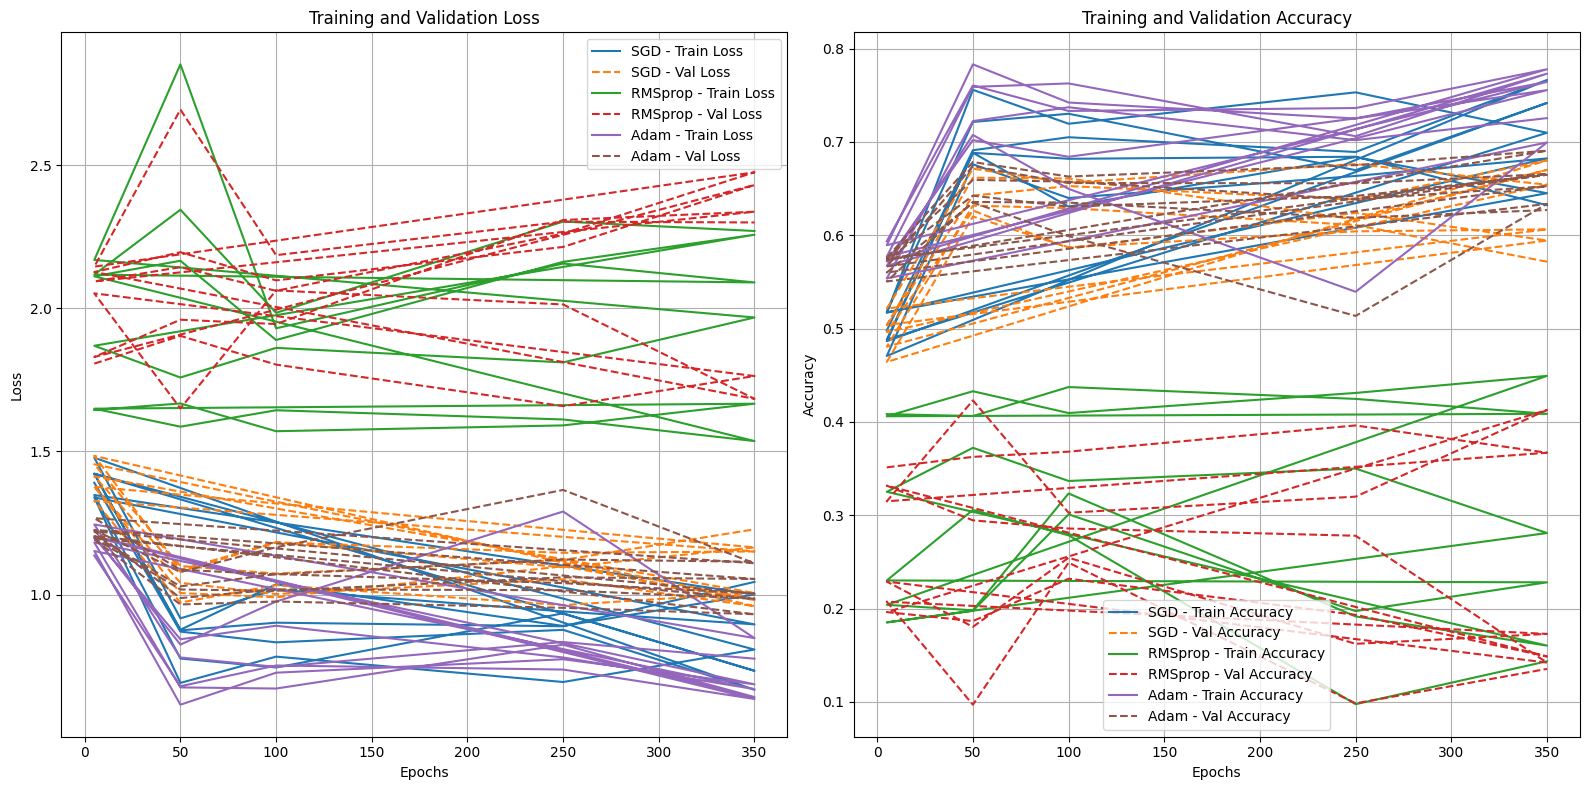

In [14]:
# Create visualizations for loss and accuracy
plt.figure(figsize=(16, 8))

# Plot training and validation loss
plt.subplot(1, 2, 1)
for optimizer in results_df['Optimizer'].unique():
    subset = results_df[results_df['Optimizer'] == optimizer]
    plt.plot(subset['Epochs'], subset['Train Loss'], label=f'{optimizer} - Train Loss')
    plt.plot(subset['Epochs'], subset['Validation Loss'], label=f'{optimizer} - Val Loss', linestyle='--')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
for optimizer in results_df['Optimizer'].unique():
    subset = results_df[results_df['Optimizer'] == optimizer]
    plt.plot(subset['Epochs'], subset['Train Accuracy'], label=f'{optimizer} - Train Accuracy')
    plt.plot(subset['Epochs'], subset['Validation Accuracy'], label=f'{optimizer} - Val Accuracy', linestyle='--')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

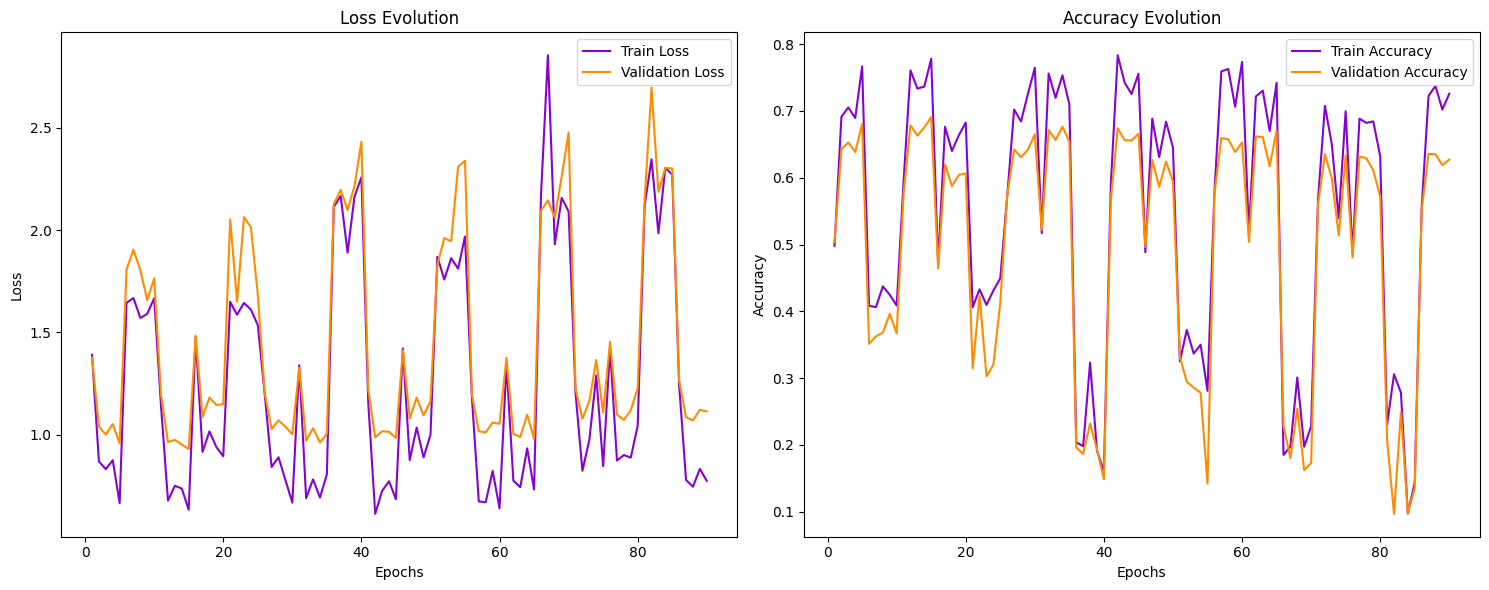

In [17]:
# Extract necessary data columns
epochs = range(1, len(results_df['Train Loss']) + 1)
train_loss = results_df['Train Loss']
val_loss = results_df['Validation Loss']
train_accuracy = results_df['Train Accuracy']
val_accuracy = results_df['Validation Accuracy']

# Plot the metrics
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='#8502d1')
plt.plot(epochs, val_loss, label='Validation Loss', color='darkorange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='#8502d1')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='darkorange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

In [18]:
# Ensure model is in evaluation mode
model.eval()

# Initialize variables to track test loss and predictions
test_loss = 0.0
all_preds = []
all_labels = []

# Use no_grad for evaluation to save memory and compute
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Compute test loss
test_loss /= len(test_loader)

# Calculate metrics
test_acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# Print results
print('\nTest Accuracy:', test_acc)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1)
print('Test Loss:    ', test_loss)


Test Accuracy: 0.6609
Test Precision: 0.6657199122588447
Test Recall: 0.6609
Test F1 Score: 0.6587044216555771
Test Loss:     1.0284739672383176
